In [1]:
# Constants

months_list = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 
               'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
invalid_value = -999
data_timezone = 'America/Sao_Paulo'

In [2]:
# Imports

import os
import math

from datetime import timezone, datetime, timedelta

import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import pysal
import contextily
import xarray
import datashader

from geopy import distance
from geopy.point import Point

from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.geometry import LineString
from shapely.ops import split

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings('ignore')

# import locale
# locale.setlocale(locale.LC_ALL, 'pt')

/Users/josebraz/opt/anaconda3/lib/python3.9/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(


In [3]:
# Configure the Dask client
import dask
from dask.distributed import Client
import dask.dataframe as dd

client = Client(n_workers=3)
client

2023-04-27 21:24:08,622 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_w/p_qvzcdx4kncfbdcftd01tf80000gn/T/dask-worker-space/worker-si2oe05m', purging
2023-04-27 21:24:08,622 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_w/p_qvzcdx4kncfbdcftd01tf80000gn/T/dask-worker-space/worker-yb2d82gy', purging
2023-04-27 21:24:08,623 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_w/p_qvzcdx4kncfbdcftd01tf80000gn/T/dask-worker-space/worker-5qe_zyly', purging
2023-04-27 21:24:08,623 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_w/p_qvzcdx4kncfbdcftd01tf80000gn/T/dask-worker-space/worker-h5mfo0kl', purging
2023-04-27 21:24:08,624 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/_w/p_qvzcdx4kncfbdcftd01tf80000gn/T/dask-worker-space/worker-xeqj_kjm', purging
2023-04-27 21:24:08,624 - distributed.diskutils - INFO - Found st

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 9,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64079,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 9
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:64092,Total threads: 3
Dashboard: http://127.0.0.1:64095/status,Memory: 2.67 GiB
Nanny: tcp://127.0.0.1:64082,


In [13]:
# Get all csv files in the burn_folder

directory = os.getcwd()
burn_folder = os.path.join(directory, "data")
data_parsed_file = os.path.join(directory, 'data_parsed.h5')
if os.path.exists(data_parsed_file):
    print('Reading cahed dataframe...')
    df = pd.read_hdf(data_parsed_file, key='df')
else:
    csv_files = os.listdir(burn_folder)
    print("Reading {} files...".format(len(csv_files)))

    column_types = {
        'precipitacao': 'float32',
        'riscofogo': 'float32',
        'latitude': 'float64',
        'longitude': 'float64',
        'frp': 'float64'
    }

    # Create the DataFrame from csv
    df = dd.read_csv(
        os.path.join(burn_folder, "*.csv"), parse_dates=["datahora"], dtype=column_types
    )

    # optimize data and setup types
    df['diasemchuva'] = df['diasemchuva'].fillna(invalid_value).astype("int16")
    df['riscofogo'] = df['riscofogo'].mask(df['riscofogo'] == invalid_value, 0)
    df['riscofogo'] = df['riscofogo'].fillna(0).astype("bool")
    df['satelite'] = df['satelite'].str.upper().astype("category")
    df['pais'] = df['pais'].str.upper().astype("category")
    df['estado'] = df['estado'].str.upper().astype("category")
    df['municipio'] = df['municipio'].str.upper().astype("category")
    df['bioma'] = df['bioma'].str.upper().astype("category")
    df['datahora'] = df['datahora'].dt.tz_localize(timezone.utc).dt.tz_convert(data_timezone)

    df: pd.DataFrame = df.compute()
    df.to_hdf(data_parsed_file, key='df', mode='w', format="table")

print('Data frame optimized with final size: {:.2f}GB'.format(df.memory_usage(deep=True).sum()/1024**3))
df.head()

Reading cahed dataframe...
Data frame optimized with final size: 2.24GB


,datahora,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp,simp_satelite,sensor
0,1998-06-01 17:55:47-03:00,NOAA-12,BRASIL,PARAIBA,TRIUNFO,CAATINGA,-999,NaN,False,-6.60833,-38.58333,NaN,NOAA-12,AVHRR
1,1998-06-01 17:55:47-03:00,NOAA-12,BRASIL,BAHIA,MUQUEM DO SAO FRANCISCO,CERRADO,-999,NaN,False,-12.26000,-43.65167,NaN,NOAA-12,AVHRR
2,1998-06-01 17:55:47-03:00,NOAA-12,BRASIL,MATO GROSSO,RIBEIRAO CASCALHEIRA,AMAZONIA,-999,NaN,False,-12.65500,-52.05667,NaN,NOAA-12,AVHRR
3,1998-06-01 17:55:47-03:00,NOAA-12,BRASIL,SAO PAULO,ALVARO DE CARVALHO,MATA ATLANTICA,-999,NaN,False,-22.12833,-49.68333,NaN,NOAA-12,AVHRR
4,1998-06-01 17:55:47-03:00,NOAA-12,BRASIL,SAO PAULO,RIBEIRAO BRANCO,MATA ATLANTICA,-999,NaN,False,-24.31167,-48.68667,NaN,NOAA-12,AVHRR


In [436]:
benchmarck_burned_areas = pd.read_csv(os.path.join(directory, 'area_queimada_aq1km.csv'))
benchmarck_burned_areas.head()

,Ano,Mês,Amazônia,Caatinga,Cerrado,Mata Atlântica,Pampa,Pantanal,Total mensal
0,2003,1,3528,2206,157,436,1,172,6500
1,2003,2,1960,56,214,107,3,30,2370
2,2003,3,3295,80,258,286,1,38,3958
3,2003,4,1179,440,1322,421,13,56,3431
4,2003,5,2033,248,5200,3321,316,179,11297


2023-04-27 21:12:32,218 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 762.80 MiB -- Worker memory limit: 1.00 GiB


In [14]:
# Processamento dos satelites

# Vamos remover os satélites TRMM e ATSR porque temos poucos dados e poucas informações

# Muitos satélites podem ser simplificados
satelite_map = {
  'NPP-375D': 'Suomi NPP',
  'NPP-375': 'Suomi NPP',
  'AQUA_M-T': 'AQUA',
  'AQUA_M-M': 'AQUA',
  'AQUA_M': 'AQUA',
  'TERRA_M-T': 'TERRA',
  'TERRA_M-M': 'TERRA',
  'TERRA_M': 'TERRA',
  'NOAA-18D': 'NOAA-18',
  'NOAA-19D': 'NOAA-19',
  'NOAA-16N': 'NOAA-16',
  'NOAA-15D': 'NOAA-15',
  'NOAA-12D': 'NOAA-12'
}
df['simp_satelite'] = df['satelite'].map(satelite_map).fillna(df['satelite']).astype("category")

# cada satélite tem um sensor
satelite_sensors = {
  'Suomi NPP': 'VIIRS',
  'NOAA-20': 'VIIRS',
  'GOES-16': 'ABI',
  'GOES-13': 'GOES I-M',
  'GOES-12': 'GOES I-M',
  'GOES-10': 'GOES I-M',
  'GOES-08': 'GOES I-M',
  'AQUA': 'MODIS',
  'TERRA': 'MODIS',
  'NOAA-18': 'AVHRR-3',
  'NOAA-19': 'AVHRR-3',
  'NOAA-17': 'AVHRR-3',
  'NOAA-16': 'AVHRR-3',
  'NOAA-15': 'AVHRR-3',
  'NOAA-14': 'AVHRR',
  'NOAA-12': 'AVHRR',
  'MSG-03': 'SEVIRI', 
  'MSG-02': 'SEVIRI',
  'METOP-B': 'AVHRR-3', 
  'METOP-C': 'AVHRR-3',
  'ATSR': 'ATSR',
  'TRMM': 'VIRS'
}

df['sensor'] = df['simp_satelite'].map(satelite_sensors).astype("category")

# resolution of all sensors in km
resolution_map = { 
    'VIIRS': 0.5,
    'AVHRR-3': 1.1,
    'MODIS': 1.0,
    'VIRS': 2.0,
    'AVHRR': 1.1,
    'ABI': 2.0,
    'SEVIRI': 3.0,
    'GOES I-M': 4.0
}

In [15]:
# variaveis derivadas dos dados
all_satellites = df['satelite'].value_counts().index.values
simp_satellites = df['simp_satelite'].value_counts().index.values
actual_satellites = df[(df['datahora'].dt.year == 2022)]['simp_satelite'].value_counts().loc[lambda x : x > 0].index.values

print('Original satellites size:', len(all_satellites.tolist()))
print('Simplified satellites size:', len(simp_satellites.tolist()))

Original satellites size: 32
Simplified satellites size: 22


In [27]:
from matplotlib.patches import Rectangle

def plot_colortable(colors, *, ncols=4) -> plt.Figure:
    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

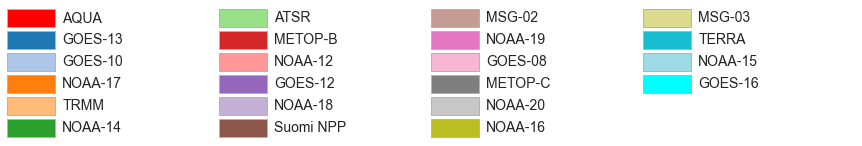

In [28]:
# Escolher cores boas paras os satélites ajuda na análise
# Ai sempre vamos usar as mesmas cores, criando gráficos 
# consistentes entre sí

import random

random.seed(43)

simp_satellites_rand = simp_satellites.tolist()
random.shuffle(simp_satellites_rand)
cmap = plt.cm.get_cmap('tab20', len(simp_satellites_rand))
satellites_colors = {}
for (i, satelite) in enumerate(simp_satellites_rand):
    satellites_colors[satelite] = cmap(i)

satellites_colors[simp_satellites_rand[0]] = (1.0, 0.0, 0.0, 1.0)
satellites_colors[simp_satellites_rand[-1]] = (0.0, 1.0, 1.0, 1.0)

plot_colortable(satellites_colors)
plt.show()

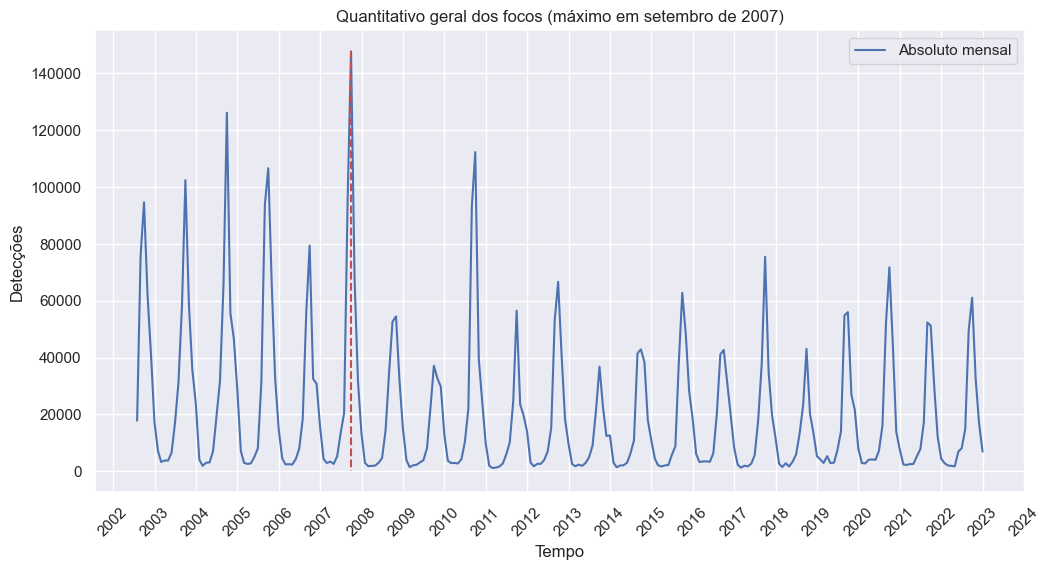

In [ ]:
# analise quantitativa dos dados com relacao a flag risco de fogo
reference_df = df[(df.satelite == 'AQUA_M-T')]

date_sem_risco_counts = reference_df.groupby([reference_df['datahora'].dt.date])['datahora'].count()

daily_df = date_sem_risco_counts.fillna(0).astype('int')
daily_df.index = pd.to_datetime(daily_df.index)
# daily_df['Total'] = daily_df.iloc[:, 0] + daily_df.iloc[:, 1]
monthly_df = daily_df.resample('M').sum()
# yearly_df = daily_df.resample('Y').sum() / 12
# mean_df = monthly_df.rolling(6, center=True).mean()

fig, ax = plt.subplots(1, 1, figsize=(12,6))
maxX: pd.Timestamp = monthly_df.idxmax()

ax.plot_date(monthly_df.index, monthly_df.values, label='Absoluto mensal', linestyle='-', marker='')
# yearly_df.plot.bar(ax=ax, label='Média anual')
# mean_df.plot(ax=ax, label='Média móvel de 6 meses')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_tick_params(rotation=45)
ax.legend()

ax.set_xlabel('Tempo')
ax.set_ylabel('Detecções')
ax.set_title('Quantitativo geral dos focos (máximo em {} de {})'.format(months_list[maxX.month-1].lower(), maxX.year))
ax.vlines(maxX, monthly_df.max(), 0, color='r', linestyles='--')

# a, b = np.polyfit(weekly_df.index.astype(np.int64), weekly_df.values, 1)
# print(a, b)
# weekly_df.map(lambda x: a*x+b).plot(ax=ax)

# weekly_df.loc['2021'].plot(y='Total', ax=axs[1], title='Quantitativo de ano de 2021')

In [84]:
# Utils functions

def sub_space(data: pd.DataFrame, min_lat: float, max_lat: float, min_lon: float, max_lon: float) -> pd.DataFrame:
    """Returns a sub data filtered by lat and lon boundary"""
    return data.query('@min_lon <= longitude <= @max_lon & @min_lat <= latitude <= @max_lat')

def get_bounds(lat: float, lon: float, size: float) -> tuple[float, float, float, float]:
    if lat == None or lon == None or size == None:
        return (None, None, None, None)
    return (lat - size/2.0, lat + size/2.0, lon - size/2.0, lon + size/2.0)

def sub_space_by_center(data: pd.DataFrame, lat: float, lon: float, size: float) -> pd.DataFrame:
    """Returns a sub data filtered by lat and lon boundary"""
    min_lat, max_lat, min_lon, max_lon = get_bounds(lat, lon, size)
    return data.query('@min_lon <= longitude <= @max_lon & @min_lat <= latitude <= @max_lat')

from typing import Iterator

def split_by_range(data: pd.DataFrame, range: pd.DatetimeIndex, time_column='datahora') -> Iterator[tuple[pd.DataFrame, pd.Timestamp]]:
    """Returns a list of dataframe with time_column grouped for each value of range"""
    if len(range) <= 1:
        return
    for (i, current) in enumerate(range):
        if i < len(range) - 1:
            next = range[i+1]
            yield (data.query(f'@current <= {time_column} < @next'), current)
            # yield (data[(data[time_column] >= current) & (data[time_column] < next)], current)

def grid_to_dataframe(grid: xarray.DataArray) -> pd.DataFrame:
    data = grid.to_pandas().unstack()
    frame =  data.where(data > 0).dropna().reset_index().rename(columns={0: "value"}) 
    return frame

from matplotlib_scalebar.scalebar import ScaleBar

def configure_geografic_axes(ax: plt.Axes, min_lon: float, max_lon: float, 
                             min_lat: float, max_lat: float):
    if min_lat != None and max_lat != None and min_lon != None and max_lon != None:
        width = distance.distance((max_lat, min_lon), (max_lat, max_lon)).m
        ax.add_artist(ScaleBar(width / abs(max_lon - min_lon), units='m'))
        x_lim = [min_lon, max_lon]
        y_lim = [min_lat, max_lat]
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
    ax.xaxis.set_major_locator(mtick.MaxNLocator(4))
    ax.xaxis.set_major_formatter(lambda x, pos: '{:.2f}{}'.format(abs(x), 'W' if x < 0 else 'E'))
    ax.yaxis.set_major_locator(mtick.MaxNLocator(5))
    ax.yaxis.set_major_formatter(lambda y, pos: '{:.2f}{}'.format(abs(y), 'S' if y < 0 else 'N'))
    # x_size = abs(max_lon - min_lon)
    # y_size = abs(max_lat - min_lat)
    # dem = Grid(nxny=(4, 4), dxdy=(x_size/4, y_size/4), x0y0=(max_lat, max_lon))
    # print(dem.ll_coordinates)
    # # g = GoogleVisibleMap(x=x_lim, y=y_lim, crs=dem, maptype='satellite')
    # # ggl_img = g.get_vardata()
    # sm = Map(dem, factor=1, countries=False)
    # sm.visualize(ax=ax)

def compute_grid(data: pd.DataFrame, min_lat: float = None, max_lat: float = None, 
                 min_lon: float = None, max_lon: float = None, 
                 aggr_dist = distance.Distance(kilometers=1)) -> xarray.DataArray:
    if not min_lat:
        min_lat = data['latitude'].min()
    if not max_lat:
        max_lat = data['latitude'].max()
    if not min_lon:
        min_lon = data['longitude'].min()
    if not max_lon:
        max_lon = data['longitude'].max()

     # calculate the grid (agregate)
    width_bottom = distance.distance((min_lat, min_lon), (min_lat, max_lon))
    width_top = distance.distance((max_lat, min_lon), (max_lat, max_lon))

    height_left = distance.distance((min_lat, min_lon), (max_lat, min_lon))
    height_right = distance.distance((min_lat, max_lon), (max_lat, max_lon))

    width = max(width_top, width_bottom)
    height = max(height_left, height_right)

    cvs = datashader.Canvas(
        plot_width=int(width/aggr_dist), 
        plot_height=int(height/aggr_dist),
        x_range=(min_lon, max_lon),
        y_range=(min_lat, max_lat)
    )
    return cvs.points(data, x="longitude", y="latitude")

flat_map = lambda f, xs: [y for ys in xs for y in f(ys)]


In [17]:
import math


class AltAzimuthRange(object):
    default_lat = None
    default_long = None
    default_elv = None

    def __init__(self):
        if AltAzimuthRange.default_lat and AltAzimuthRange.default_long and AltAzimuthRange.default_elv:
            self.a = {'lat': AltAzimuthRange.default_lat, 'lon': AltAzimuthRange.default_long,
                      'elv': AltAzimuthRange.default_elv}
        else:
            self.a = None
        self.b = None
        pass

    def observer(self, lat: float, long: float, altitude: float):
        # latitude, longitude, meters above sea level (can be lower than zero)
        self.a = {'lat': lat, 'lon': long, 'elv': altitude}

    def target(self, lat: float, long: float, altitude: float):
        # latitude, longitude, meters above sea level (can be lower than zero)
        self.b = {'lat': lat, 'lon': long, 'elv': altitude}

    def calculate(self) -> dict:
        if not self.a:
            raise Exception(
                "Observer is not defined. Fix this by using instance_name.observer(lat,long,altitude) method")
        if not self.b:
            raise Exception(
                "Target location is not defined. Fix this by using instance_name.target(lat,long,altitude) method")
        ap, bp = AltAzimuthRange.LocationToPoint(self.a), AltAzimuthRange.LocationToPoint(self.b)
        br = AltAzimuthRange.RotateGlobe(self.b, self.a, bp['radius'])
        dist = round(AltAzimuthRange.Distance(ap, bp), 2)
        if br['z'] * br['z'] + br['y'] * br['y'] > 1.0e-6:
            theta = math.atan2(br['z'], br['y']) * 180.0 / math.pi
            azimuth = 90.0 - theta
            if azimuth < 0.0:
                azimuth += 360.0
            if azimuth > 360.0:
                azimuth -= 360.0
            azimuth = round(azimuth, 2)
            bma = AltAzimuthRange.NormalizeVectorDiff(bp, ap)
            if bma:
                elevation = 90.0 - (180.0 / math.pi) * math.acos(
                    bma['x'] * ap['nx'] + bma['y'] * ap['ny'] + bma['z'] * ap['nz'])
                elevation = round(elevation, 2)
            else:
                elevation = None
        else:
            azimuth = None
            elevation = None
        return {"azimuth": azimuth, "elevation": elevation, "distance": dist}

    @staticmethod
    def default_observer(lat: float, long: float, altitude: float):
        AltAzimuthRange.default_lat = lat
        AltAzimuthRange.default_long = long
        AltAzimuthRange.default_elv = altitude

    @staticmethod
    def Distance(ap, bp):
        dx = ap['x'] - bp['x']
        dy = ap['y'] - bp['y']
        dz = ap['z'] - bp['z']
        return math.sqrt(dx * dx + dy * dy + dz * dz)

    @staticmethod
    def GeocentricLatitude(lat):
        e2 = 0.00669437999014
        clat = math.atan((1.0 - e2) * math.tan(lat))
        return clat

    @staticmethod
    def EarthRadiusInMeters(latituderadians):
        a = 6378137.0
        b = 6356752.3
        cos = math.cos(latituderadians)
        sin = math.sin(latituderadians)
        t1 = a * a * cos
        t2 = b * b * sin
        t3 = a * cos
        t4 = b * sin
        return math.sqrt((t1 * t1 + t2 * t2) / (t3 * t3 + t4 * t4))

    @staticmethod
    def LocationToPoint(c):
        lat = c['lat'] * math.pi / 180.0
        lon = c['lon'] * math.pi / 180.0
        radius = AltAzimuthRange.EarthRadiusInMeters(lat)
        clat = AltAzimuthRange.GeocentricLatitude(lat)

        cos_lon = math.cos(lon)
        sin_lon = math.sin(lon)
        cos_lat = math.cos(clat)
        sin_lat = math.sin(clat)
        x = radius * cos_lon * cos_lat
        y = radius * sin_lon * cos_lat
        z = radius * sin_lat

        cos_glat = math.cos(lat)
        sin_glat = math.sin(lat)

        nx = cos_glat * cos_lon
        ny = cos_glat * sin_lon
        nz = sin_glat

        x += c['elv'] * nx
        y += c['elv'] * ny
        z += c['elv'] * nz

        return {'x': x, 'y': y, 'z': z, 'radius': radius, 'nx': nx, 'ny': ny, 'nz': nz}

    @staticmethod
    def NormalizeVectorDiff(b, a):
        dx = b['x'] - a['x']
        dy = b['y'] - a['y']
        dz = b['z'] - a['z']
        dist2 = dx * dx + dy * dy + dz * dz
        if dist2 == 0:
            return None
        dist = math.sqrt(dist2)
        return {'x': (dx / dist), 'y': (dy / dist), 'z': (dz / dist), 'radius': 1.0}

    @staticmethod
    def RotateGlobe(b, a, b_radius):
        br = {'lat': b['lat'], 'lon': (b['lon'] - a['lon']), 'elv': b['elv']}
        brp = AltAzimuthRange.LocationToPoint(br)

        alat = AltAzimuthRange.GeocentricLatitude(-a['lat'] * math.pi / 180.0)
        acos = math.cos(alat)
        asin = math.sin(alat)

        bx = (brp['x'] * acos) - (brp['z'] * asin)
        by = brp['y']
        bz = (brp['x'] * asin) + (brp['z'] * acos)

        return {'x': bx, 'y': by, 'z': bz, 'radius': b_radius}

In [22]:
from pyorbital.orbital import Orbital
class SatellitesMeasureGeometry:
    orbital_cache = {}

    def __init__(self, data: pd.DataFrame, crs: str = 'EPSG:4326'):
        self.data = data
        self.crs = crs
        self.cache_areas: gpd.GeoDataFrame = None
        self.data_cache: dict[tuple[datetime, str], tuple] = dict()

    def get_satelites_measures_area(self) -> gpd.GeoDataFrame:
        """"Returns a GeoDataFrame contains only the name of the satellite and the geometry of measuase"""
        if self.cache_areas is None:
            squares = self._get_squares()
            polis = squares.map(lambda x: Polygon(x))
            simp_satellites = self.data['simp_satelite'].astype('str')
            self.cache_areas = gpd.GeoDataFrame(
                { 'simp_satelite': simp_satellites }, 
                crs=self.crs,
                geometry=polis
            )
        return self.cache_areas 

    @staticmethod
    def get_orbital(satelite: str) -> Orbital:
        if satelite not in SatellitesMeasureGeometry.orbital_cache.keys():
            SatellitesMeasureGeometry.orbital_cache[satelite] = Orbital(satelite)
        return SatellitesMeasureGeometry.orbital_cache[satelite]

    @staticmethod
    def _is_geostationary(satellite_name: str) -> bool:
        return satellite_name.startswith("GOES") or satellite_name.startswith("MSG")

    @staticmethod
    def _rotate_square(square: np.array, theta_x: float=0.0, theta_y: float=0.0) -> np.array:
        rotate = np.array([
            [np.cos(theta_x), -np.sin(theta_y)],
            [np.sin(theta_x),  np.cos(theta_y)]
        ])
        translate = square.mean(axis=0)
        out = square - translate
        out = (rotate @ out.T).T
        out = out + translate
        return out

    @staticmethod
    def _get_square(y: float, x: float, resolution: float, satellite_name: str, inclination: float,
                satellite_lon: float, satellite_lat: float, alt: float) -> np.array:
        need_adjust = alt >= 1000
        if need_adjust:
            satellite = AltAzimuthRange()
            satellite.observer(y, x, 0)
            satellite.target(satellite_lat, satellite_lon, alt * 1000)
            data = satellite.calculate()
            dist = data['distance']
            azimuth = data['azimuth']

            change_dist = ((dist / 1000) - alt) * 8 # fator de ajuste (validar)
            real_x_distance = alt + change_dist * math.cos(math.radians(azimuth % 90)) # in km
            real_y_distance = alt + change_dist * math.sin(math.radians(azimuth % 90)) # in km

            adjust_x = (real_x_distance * resolution/2.0) / alt
            adjust_y = (real_y_distance * resolution/2.0) / alt
            resolution_x, resolution_y = adjust_x * 2, adjust_y * 2
            inclination_x, inclination_y = 0.0, math.radians(5) #math.radians(satellite_lon - x), math.radians(satellite_lat - y) 
        else:
            resolution_x, resolution_y = resolution, resolution
            inclination_x, inclination_y = inclination, inclination
        geodesic_x = distance.geodesic(kilometers=resolution_x / 2.0)
        geodesic_y = distance.geodesic(kilometers=resolution_y / 2.0)

        top: Point = geodesic_y.destination((y, x), 0)
        bottom: Point = geodesic_y.destination((y, x), 180)
        right: Point = geodesic_x.destination((y, x), 90)
        left: Point = geodesic_x.destination((y, x), -90)
        # print(satellite_name, satellite_lon, satellite_lat, alt, 'distance =', (abs(satellite_lon-x), abs(satellite_lat-y)))
        simple_square = np.array([
            [left.longitude, top.latitude], # top left
            [right.longitude, top.latitude], # top rigth
            [right.longitude, bottom.latitude], # bottom rigth
            [left.longitude, bottom.latitude] # bottom left
        ])
        # print(real_x_distance, real_y_distance)
        return SatellitesMeasureGeometry._rotate_square(simple_square, inclination_x, inclination_y)

    def _get_satellite_data(self, time: pd.Timestamp, satellite_name: str) -> tuple[str, float, float, float, float]:
        """Returns satellite name, inclination, longitude, latitude and alture"""
        key = (time.to_pydatetime(), satellite_name)
        if key in self.data_cache:
            return self.data_cache[key]
        
        if satellite_name == 'GOES-16':
            return (satellite_name, 0.0, -75.190, 0.0, 35000.0)
        if satellite_name == 'MSG-03':
            # satellite_name = 'METEOSAT-10'
            return (satellite_name, 0.0, -75.190, 0.0, 35000.0) # TODO
        orb = SatellitesMeasureGeometry.get_orbital(satellite_name)
        loc1 = orb.get_lonlatalt(time)

        # the inclination is negative when the satellite is moving from top to bottom
        # of the earth. we get it comparing the latitude of two points close in the time
        loc2 = orb.get_lonlatalt(time + timedelta(seconds=5))
        descending = loc1[1] > loc2[1]
        inclination = orb.orbit_elements.inclination * (-1 if descending else 1)
        result = satellite_name, inclination, *loc1
        
        self.data_cache[key] = result
        return result

    def _get_squares(self) -> pd.Series:
        if len(self.data) == 0: return pd.Series([])
        points = pd.DataFrame({
            'latitude': self.data['latitude'], 
            'longitude': self.data['longitude'], 
            'resolution': self.data['sensor'].map(resolution_map)
        })
        data_temp = self.data[['datahora', 'simp_satelite']].apply(
            lambda d: self._get_satellite_data(*d.values), axis=1, result_type='expand')
        points[['name', 'inclination', 'satellite_lon', 'satellite_lat', 'satellite_alt']] = data_temp
        return points.apply(lambda d: SatellitesMeasureGeometry._get_square(*d.values), axis=1)


In [88]:
def show_separated_satelittes(data: pd.DataFrame, center_lat: float = None, 
                              center_lon: float = None, size: float = None, 
                              width: float = 20, axs: list[plt.Axes] = None):
    min_lat, max_lat, min_lon, max_lon = get_bounds(center_lat, center_lon, size)

    unique_satelites = data['satelite'].unique()
    n = len(unique_satelites)
    if n == 0: return

    if axs is None:
        max_col = min(4, n)
        rows = math.ceil(n / max_col)
        fig, axs = plt.subplots(rows, max_col, sharex= True, sharey=True, figsize=(width, (width/max_col) * rows))
        fig.tight_layout()
        axs = axs.flat

    for i, ax in enumerate(axs):
        if i >= n: break
        ax: plt.Axes
        configure_geografic_axes(ax, min_lon, max_lon, min_lat, max_lat)
        satelite = unique_satelites[i]
        data_satelite = data[data['satelite'] == satelite]
        satellites_data = SatellitesMeasureGeometry(data_satelite)
        dataframe = satellites_data.get_satelites_measures_area()
        color = satellites_colors[data_satelite.iloc[0]['simp_satelite']]
        dataframe.plot(
            ax=ax,
            color=color,
            alpha=0.5,
            legend=True,
            edgecolor=color,
            linewidth=1
        )
        ax.set_title(satelite)

def show_satelites_points(data: pd.DataFrame, ax: plt.Axes, markersize: float = 3):
    satelites_data = data['simp_satelite'].value_counts().where(lambda x : x != 0).dropna()
    for (i, satelite) in enumerate(satelites_data.index.tolist()):
        current = data[data['simp_satelite'] == satelite]
        gpd.GeoDataFrame(
            current,
            geometry=gpd.points_from_xy(current.longitude, current.latitude),
            crs="EPSG:4326"
        ).plot(
            ax=ax,
            color=satellites_colors[satelite],
            markersize=markersize,
            label="{} - {}".format(satelite, int(satelites_data[satelite]))
        )
    # ax.legend(markerscale=3)


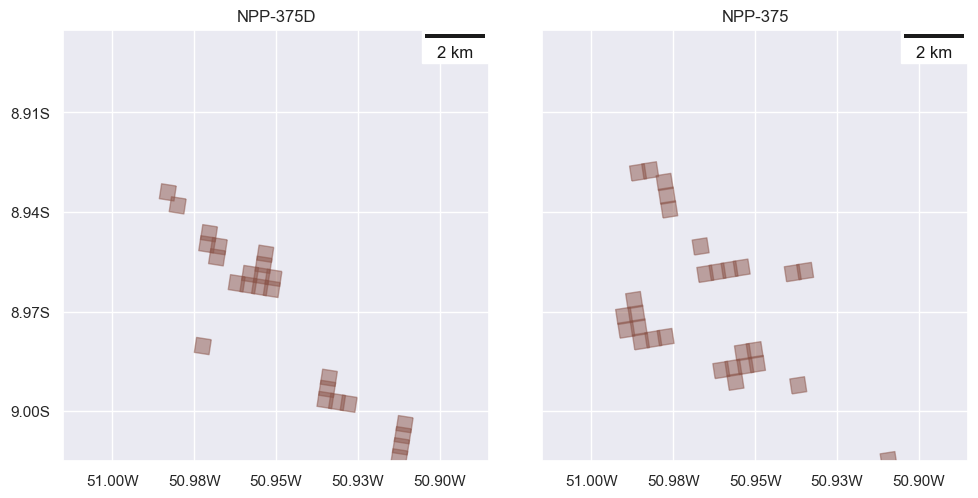

In [59]:
center_lat, center_lon, size = -8.95, -50.95, 0.13
data_temp = sub_space_by_center(df.query("'2022-09-02 00:00:00-03:00' < datahora < '2022-09-02 23:59:59-03:00' and simp_satelite == 'Suomi NPP'"), center_lat, center_lon, size)
show_separated_satelittes(data_temp, center_lat, center_lon, size, width=10)

Text(0.5, 1.0, 'Áreas Descendente')

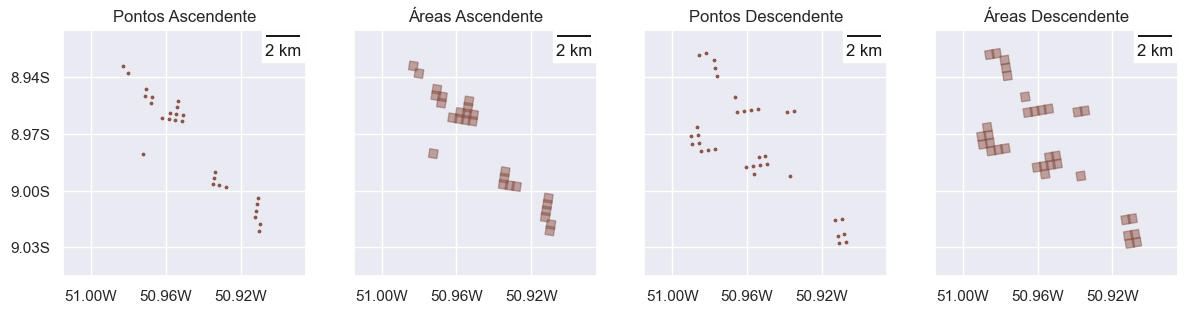

In [91]:
fig, axs = plt.subplots(1, 4, sharex= True, sharey=True, figsize=(12, 20))
fig.tight_layout()
axs = axs.flat

center_lat, center_lon, size = -8.98, -50.95, 0.13
data_temp = sub_space_by_center(df.query("'2022-09-02 00:00:00-03:00' < datahora < '2022-09-02 23:59:59-03:00' and simp_satelite == 'Suomi NPP'"), center_lat, center_lon, size)

min_lat, max_lat, min_lon, max_lon = get_bounds(center_lat, center_lon, size)

show_satelites_points(data_temp[data_temp['satelite'] == 'NPP-375D'], ax=axs[0])
axs[0].set_title('Pontos Ascendente')
configure_geografic_axes(axs[0], min_lon, max_lon, min_lat, max_lat)

show_satelites_points(data_temp[data_temp['satelite'] == 'NPP-375'], ax=axs[2])
axs[2].set_title('Pontos Descendente')
configure_geografic_axes(axs[2], min_lon, max_lon, min_lat, max_lat)

show_separated_satelittes(data_temp, center_lat, center_lon, size, axs=[axs[1], axs[3]])
axs[1].set_title('Áreas Ascendente')
axs[3].set_title('Áreas Descendente')


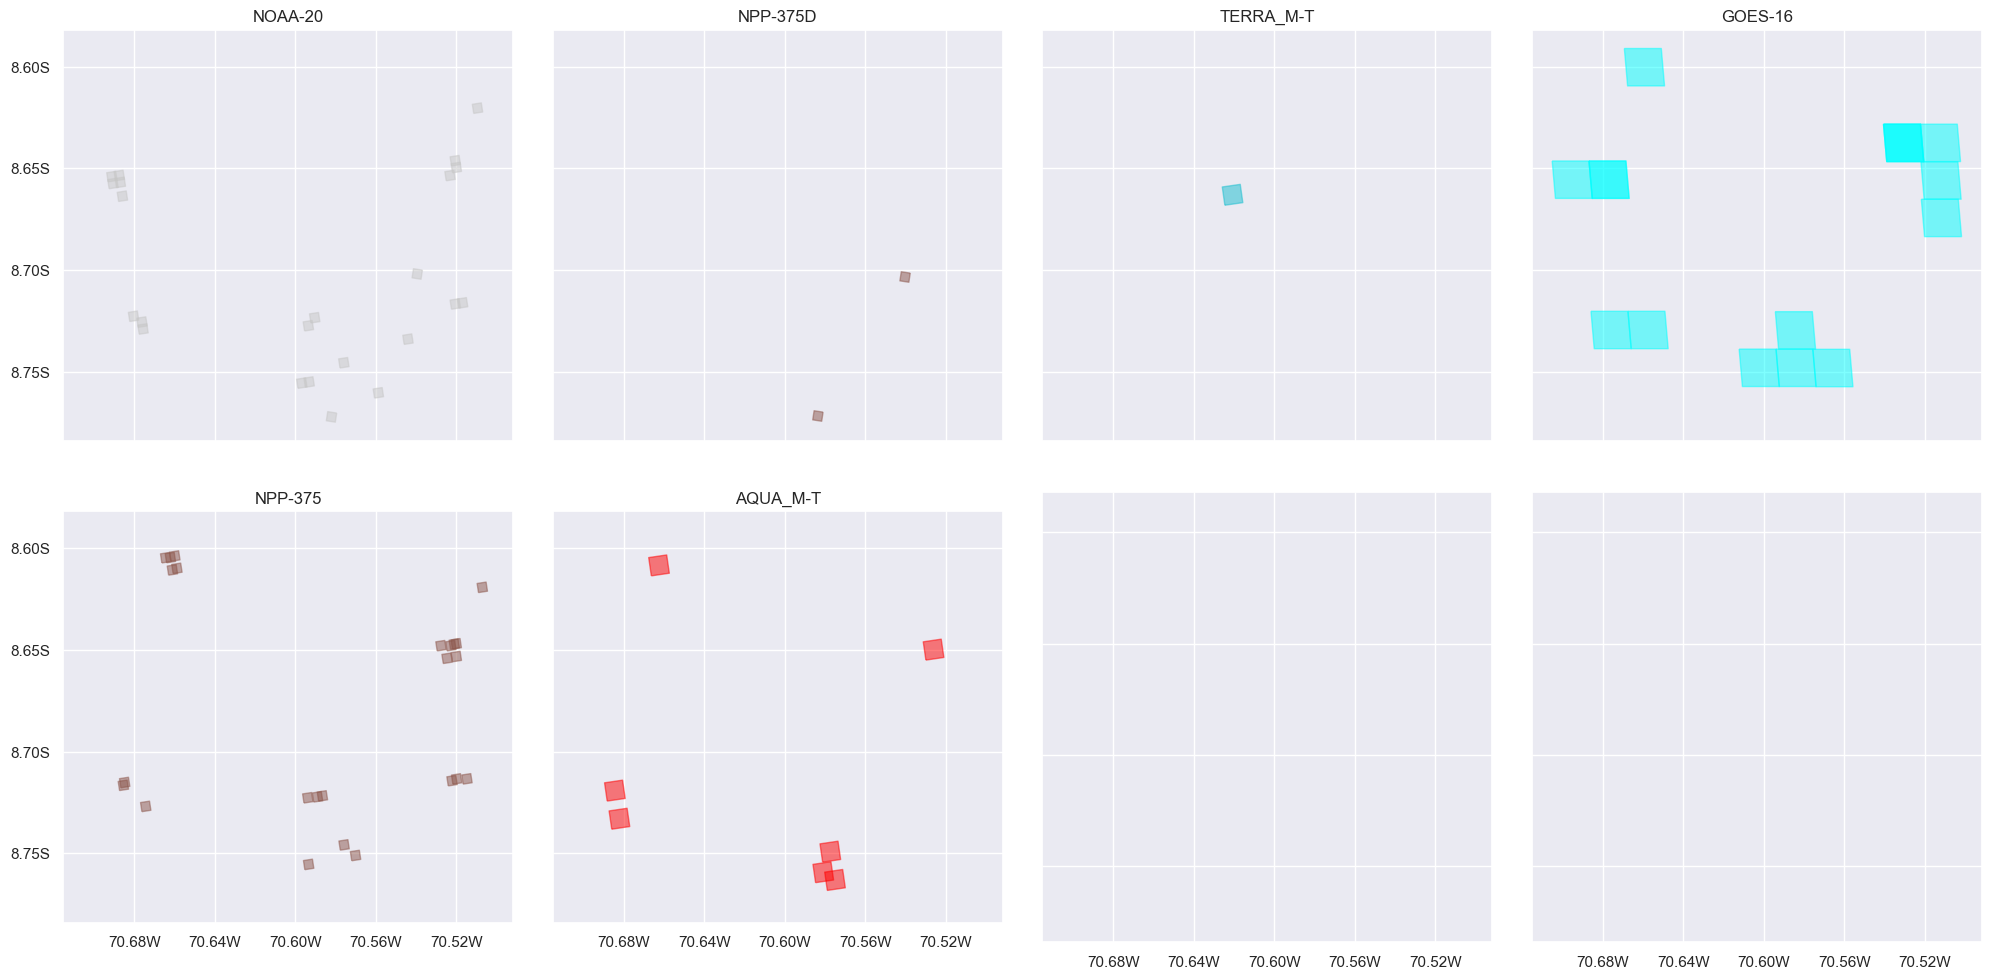

In [429]:
center_lat, center_lon, size = -8.70, -70.60, 0.20
data_temp = sub_space_by_center(df.query("'2022-09-02 00:00:00-03:00' < datahora < '2022-09-02 23:59:59-03:00'"), center_lat, center_lon, size)
show_separated_satelittes(data_temp)

In [118]:
from pyproj import Geod

default_threshold: float = 5

class SatellitesExplore:

    def __init__(self, data: pd.DataFrame, quadrat_width: float = 0.005):
        
        self.satellites_data = SatellitesMeasureGeometry(data)
        self.geod = Geod(ellps="WGS84")
        self.dataframe = self.satellites_data.get_satelites_measures_area()
        self.data_color = self.dataframe['simp_satelite'].map(satellites_colors)
        self.quadrat_width = quadrat_width

        self.all_evaluated_quads: gpd.GeoDataFrame = None
        self.grouped_quads: list[MultiPolygon] = None
        self.unary_union: MultiPolygon = None

    def plot(self, width: int = 20, center_lat: float = None, center_lon: float = None, 
             size: float = None, only_quads_evaluated: bool = False, axs: list[plt.Axes] = None,
             with_color_bar: bool = True, with_base_map: bool = False, threshold: float = default_threshold):
        if axs == None:
            n = 1 if only_quads_evaluated else 4 
            if with_color_bar:
                height = (width - width * 0.15) / n # color bar space 
            else:
                height = width / n
            fig, axs = plt.subplots(1, n, sharey=True, sharex=True, figsize=(width, height))
            fig.tight_layout(pad=0.0)
            axs = axs.flat
        
        if only_quads_evaluated: 
            self.show_satellites_quads_evaluated(axs[0], with_color_bar=with_color_bar)
        else:
            self.show_satellites_points(axs[0], with_base_map=with_base_map)
            self.show_satellites_areas(axs[1], with_base_map=with_base_map)
            self.show_satellites_quads_evaluated(axs[2], with_color_bar=with_color_bar)
            self.show_satellites_quads_filtered(axs[3], with_base_map=with_base_map, threshold=threshold)
        
        min_lat, max_lat, min_lon, max_lon = get_bounds(center_lat, center_lon, size)
        for ax in axs:
            configure_geografic_axes(ax, min_lon, max_lon, min_lat, max_lat)

    def show_satellites_points(self, ax: plt.Axes, with_base_map: bool = False, markersize: float = 3):
        if len(self.dataframe) == 0: return
        self.dataframe.representative_point().plot(ax=ax, color=self.data_color, markersize=markersize)
        if with_base_map:
            contextily.add_basemap(ax, crs=self.dataframe.crs,
                source=contextily.providers.CartoDB.PositronNoLabels)

    def show_satellites_areas(self, ax: plt.Axes, with_base_map: bool = False):
        if len(self.dataframe) == 0: return
        self.dataframe.plot(ax=ax, color=self.data_color, categorical=True, alpha=0.2,
            legend=True, edgecolor=self.data_color, linewidth=1)
        if with_base_map:
            contextily.add_basemap(ax, crs=self.dataframe.crs,
                source=contextily.providers.CartoDB.PositronNoLabels)
    
    def show_satellites_quads_evaluated(self, ax: plt.Axes, with_color_bar: bool = True):
        if len(self.dataframe) == 0: return
        self.get_all_evaluated_quads().plot(
            ax=ax, edgecolor='k', alpha=0.5, linewidth=1, column='value', cmap='hot', legend=with_color_bar)
        
    def show_satellites_quads_filtered(self, ax: plt.Axes, threshold: float = default_threshold, 
                                       with_base_map: bool = False):
        if len(self.dataframe) == 0: return
        self.show_satellites_areas(ax, with_base_map=with_base_map)
        ax.legend(title = "{:.2f}Km²".format(self.get_total_area_m_2(threshold=threshold) / 1000000), loc='lower left')
        points: gpd.GeoDataFrame = self.get_all_evaluated_quads()
        points[points['value'] >= threshold].plot(
            ax=ax, edgecolor='k', alpha=0.5, linewidth=1)
    
    def get_total_area_m_2(self, threshold: float = default_threshold) -> float:
        points: gpd.GeoDataFrame = self.get_all_evaluated_quads()
        polygons = points[points['value'] >= threshold].geometry
        return sum(map(lambda poly: self._get_area_m_2(poly), polygons))
    
    def get_final_poly_result(self, threshold: float = default_threshold) -> MultiPolygon:
        points: gpd.GeoDataFrame = self.get_all_evaluated_quads()
        polygons = SatellitesExplore._get_unary_union_list(points[points['value'] >= threshold])
        return MultiPolygon(polygons)

    def get_all_evaluated_quads(self) -> gpd.GeoDataFrame:
        if self.all_evaluated_quads is None:
            grouped_quads: list[MultiPolygon] = self._get_grouped_quads()
            points: list[tuple[float, Polygon]] = flat_map(
                lambda multi_polygon: self._get_evaluated_quads(multi_polygon, self.dataframe.sindex), 
                grouped_quads
            )
            value, geometry = zip(*points)
            data = { 'value' : value, 'geometry': geometry }
            self.all_evaluated_quads = gpd.GeoDataFrame(data, crs=self.dataframe.crs)
        return self.all_evaluated_quads

    def _get_area_m_2(self, polygon: Polygon) -> float:
        area, perimeter = self.geod.geometry_area_perimeter(polygon)
        return abs(area)
    
    def _evaluate_quads(self, polygon: Polygon, sindex) -> float:
        """
        Evaluate the polygon with some criterias:
            
        """
        polygon_area = polygon.area
        min_area = polygon_area * 0.2

        indexes_intersept: list[int] = sindex.query(polygon)
        possible_matches: gpd.GeoDataFrame = self.dataframe.iloc[indexes_intersept]
        precise_matches: gpd.GeoDataFrame = possible_matches[possible_matches.intersects(polygon)]
        intersection_areas = np.array([polygon.intersection(x).area for x in precise_matches.geometry])
        
        filtered_matches: gpd.GeoDataFrame = precise_matches[intersection_areas > min_area]

        uniques_satellites = len(filtered_matches['simp_satelite'].unique())
        intersection_areas_per_poly = intersection_areas.sum() / polygon_area

        return (uniques_satellites ** 2) + min(intersection_areas_per_poly, 3.99)

    def _get_evaluated_quads(self, quadrat_cut: MultiPolygon, sindex) -> list[tuple[float, Polygon]]:
        """
        Returns a list of tuple (value, polygon)
        """
        return [(self._evaluate_quads(poly, sindex), poly) for poly in quadrat_cut.geoms]
        
    def _get_unary_union(self) -> list[Polygon]:
        """
        Cached way to get unary union set.
        """
        if self.unary_union == None:
            self.unary_union = SatellitesExplore._get_unary_union_list(self.dataframe)
        return self.unary_union
    
    def _get_grouped_quads(self) -> list[MultiPolygon]:
        """
        Cached way to get the splited quadrants for all elements of unary union set
        """
        if self.grouped_quads == None:
            self.grouped_quads = [SatellitesExplore._split_quads(poly, quadrat_width=self.quadrat_width) for poly in self._get_unary_union()]
        return self.grouped_quads
    
    @staticmethod
    def _get_unary_union_list(dataframe: gpd.GeoDataFrame) -> list[Polygon]:
        temp_union = dataframe.unary_union
        if temp_union == None or temp_union.is_empty:
            return []
        elif isinstance(temp_union, MultiPolygon):
            return list(temp_union.geoms)
        else:
            return [temp_union]

    @staticmethod
    def _split_quads(geometry, quadrat_width: float, min_num=3) -> MultiPolygon:
        """
        Reference: osmnx/utils_geo
        
        Split a Polygon or MultiPolygon up into sub-polygons of a specified size.
        Parameters
        ----------
        geometry : shapely.geometry.Polygon or shapely.geometry.MultiPolygon
            the geometry to split up into smaller sub-polygons
        quadrat_width : numeric
            the linear width of the quadrats with which to cut up the geometry (in
            the units the geometry is in)
        min_num : int
            the minimum number of linear quadrat lines (e.g., min_num=3 would
            produce a quadrat grid of 4 squares)
        Returns
        -------
        geometry : shapely.geometry.MultiPolygon
        """
        # create n evenly spaced points between the min and max x and y bounds
        west, south, east, north = geometry.bounds
        x_num = int(np.ceil((east - west) / quadrat_width) + 1)
        y_num = int(np.ceil((north - south) / quadrat_width) + 1)
        x_points = np.linspace(west, east, num=max(x_num, min_num))
        y_points = np.linspace(south, north, num=max(y_num, min_num))

        # create a quadrat grid of lines at each of the evenly spaced points
        vertical_lines = [LineString([(x, y_points[0]), (x, y_points[-1])]) for x in x_points]
        horizont_lines = [LineString([(x_points[0], y), (x_points[-1], y)]) for y in y_points]
        lines = vertical_lines + horizont_lines

        # recursively split the geometry by each quadrat line
        geometries = [geometry]

        for line in lines:
            # split polygon by line if they intersect, otherwise just keep it
            split_geoms = [split(g, line).geoms if g.intersects(line) else [g] for g in geometries]
            # now flatten the list and process these split geoms on the next line in the list of lines
            geometries = [g for g_list in split_geoms for g in g_list]

        return MultiPolygon(geometries)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


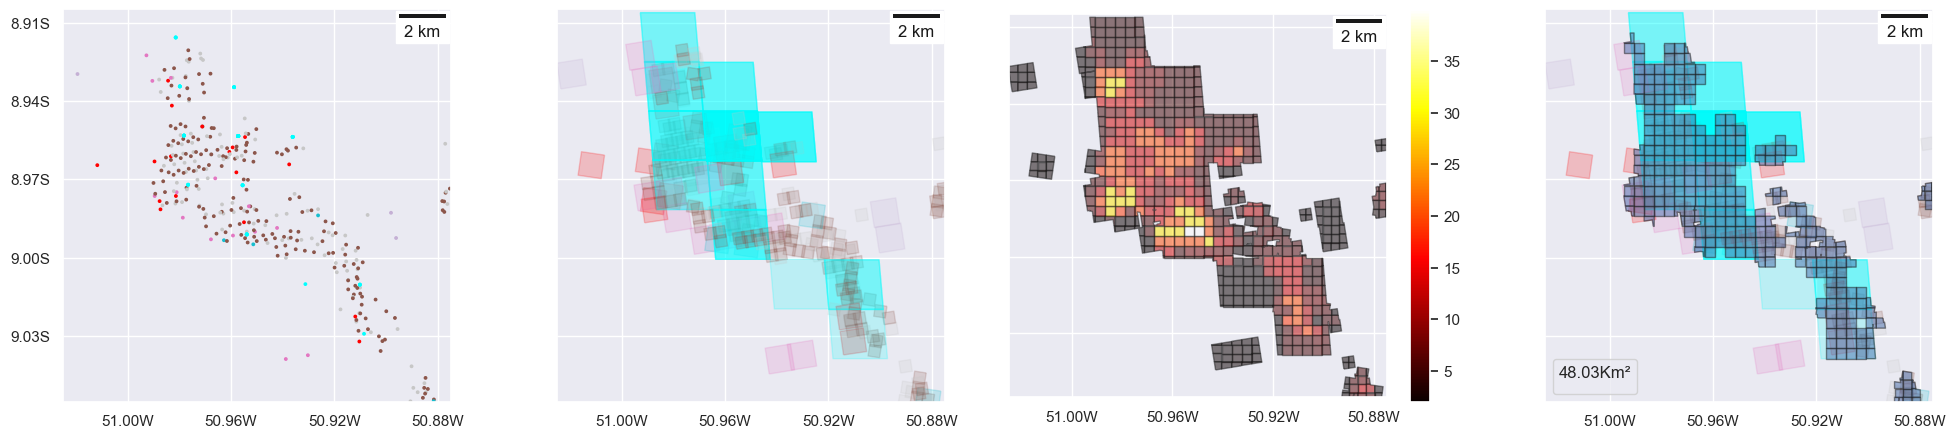

In [119]:
center_lat, center_lon, size = -8.98, -50.95, 0.15
data_temp = sub_space_by_center(df.query("'2022-09-01 00:00:00-03:00' < datahora < '2022-09-03 23:59:59-03:00'"), center_lat, center_lon, size)

explorer = SatellitesExplore(data_temp, quadrat_width=0.004)
explorer.plot(width=20, threshold=5, center_lat=center_lat, center_lon=center_lon, size=size)


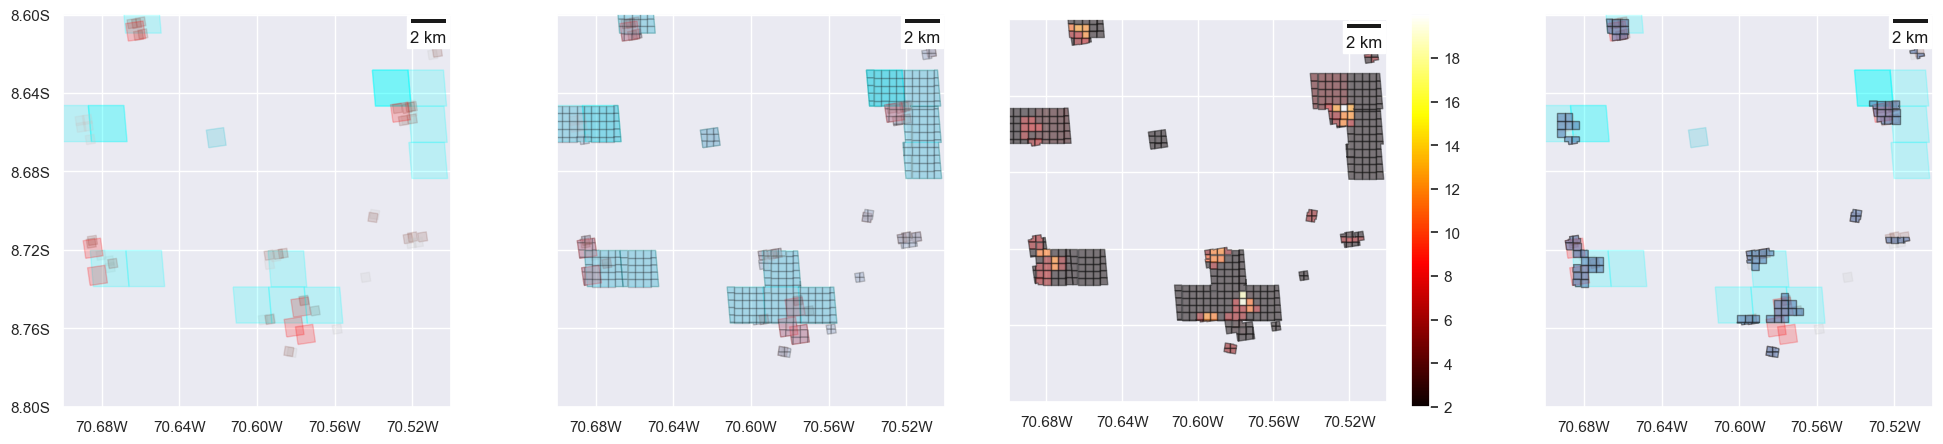

In [422]:
center_lat, center_lon, size = -8.70, -70.60, 0.20
data_temp = sub_space_by_center(df.query("'2022-09-02 00:00:00-03:00' < datahora < '2022-09-02 23:59:59-03:00'"), center_lat, center_lon, size)

explorer = SatellitesExplore(data_temp, quadrat_width=0.004)
explorer.plot(width=20, threshold=5, center_lat=center_lat, center_lon=center_lon, size=size)

In [282]:
@dask.delayed
def calculate_poly(current_data: pd.DataFrame) -> MultiPolygon:
    explorer = SatellitesExplore(current_data, quadrat_width=0.004)
    return explorer.get_final_poly_result()

def calculate_multiple_satelites_data(data: pd.DataFrame, start_date: str, freq: str, period: int, 
               center_lat: float, center_lon: float, size: float) -> dict[pd.Timestamp, MultiPolygon]:
    range = pd.date_range(start_date, freq=freq, periods=period, tz=data_timezone)
    sub_sapce = sub_space_by_center(data, center_lat, center_lon, size)

    total_polys = []
    timestamps = []
    for (current_data, timestamp) in split_by_range(sub_sapce, range):
        total_polys.append(calculate_poly(current_data))
        timestamps.append(timestamp)
    
    result = dask.compute(total_polys)[0]
    return dict(zip(timestamps, result))

def time_inter(data: pd.DataFrame, start_date: str, freq: str, period: int, 
               center_lat: float, center_lon: float, size: float) -> MultiPolygon:
    final_results = calculate_multiple_satelites_data(data=data, start_date=start_date, 
                                                      freq=freq, period=period, center_lat=center_lat, 
                                                      center_lon=center_lon, size=size)
    total_area = MultiPolygon([])
    width, columns = 20, 5
    rows = math.ceil((len(final_results) - 1) / columns)
    min_lat, max_lat, min_lon, max_lon = get_bounds(center_lat, center_lon, size)

    fig, axs = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=(width, width/columns * rows))
    fig.tight_layout(pad=0.0)
    axs = axs.flat

    for i, timestamp in enumerate(final_results):
        ax: plt.Axes = axs[i]
        multi_polygon = final_results[timestamp]
        total_area = total_area.union(multi_polygon)
        gpd.GeoDataFrame(geometry=list(total_area.geoms)).plot(
            ax=ax, edgecolor='red', color='red', alpha=0.2, linewidth=1)
        ax.set_title(timestamp.strftime('%d/%m/%Y'))
        ax.set_xlim([min_lon, max_lon])
        ax.set_ylim([min_lat, max_lat])
        ax.set_axis_off()

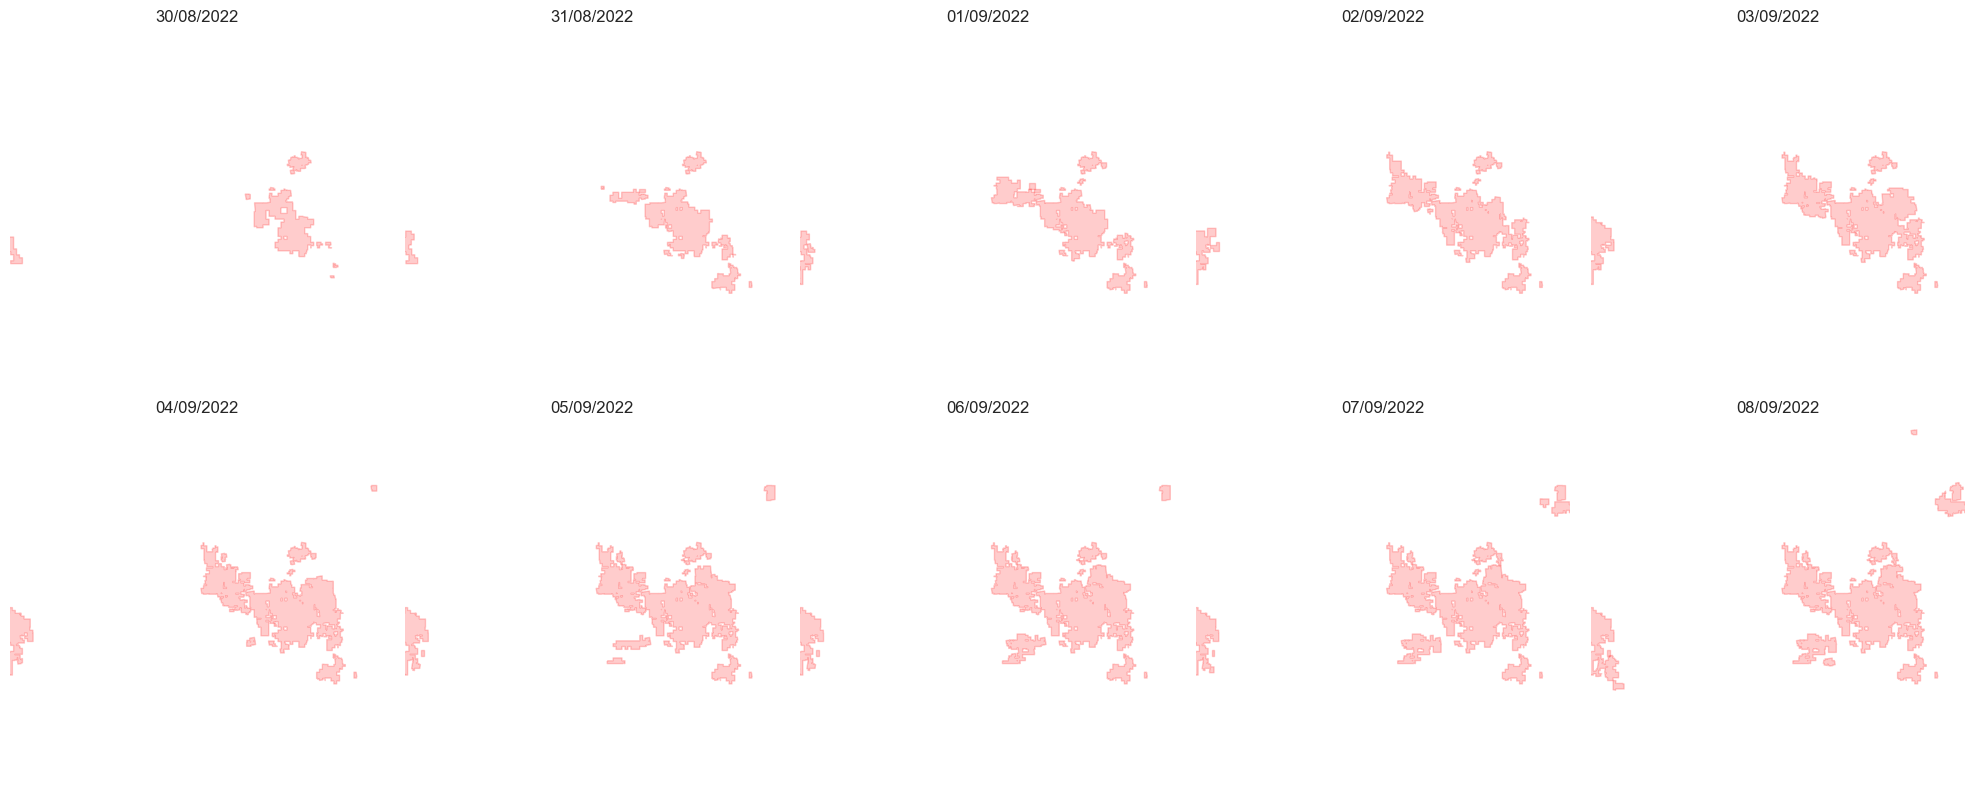

In [396]:
center_lat, center_lon, size = -9, -51, 0.50
total_area = time_inter(df, start_date='2022-08-30', freq='1D', period=11, 
           center_lat=center_lat, center_lon=center_lon, size=size)

In [43]:
@dask.delayed
def calculate_area(timestamp: pd.Timestamp, data: pd.DataFrame, quadrat_width: float, threshold: float) -> dict: 
    explorer = SatellitesExplore(data, quadrat_width=quadrat_width)
    result =  {
        'area_km2': explorer.get_total_area_m_2(threshold=threshold) / 1000000,
        'time': timestamp,
        'geometry': explorer.get_final_poly_result(threshold=threshold)
    }
    return result

one_year = pd.date_range("2021-01-01", freq="1M", periods=2, tz=data_timezone)
calc_area_task = []
for data, timestamp in split_by_range(df, one_year):
    calc_area_task.append(calculate_area(timestamp, data[data['bioma'] == 'PAMPA'], quadrat_width=0.004, threshold=5))

areas_result = dask.compute(calc_area_task)[0]

area_dataframe = gpd.GeoDataFrame(areas_result)
area_dataframe.set_index('time', inplace=True)

/Users/josebraz/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/josebraz/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/josebraz/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


Figure(2000x425)


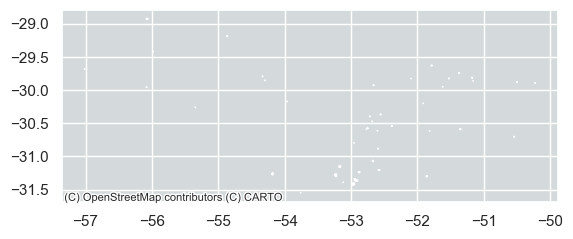

In [44]:
fig, ax = plt.subplots(1,1)
data_temp = gpd.GeoDataFrame(area_dataframe)
data_temp.plot(ax=ax, color='red')

contextily.add_basemap(
    ax, 
    crs=data_temp.crs,
    source=contextily.providers.CartoDB.Positron
)

Text(0.5, 1.0, 'Área queimada do ano de 2021 seguindo a técnica descrita neste trabalho (total: 521120.25 Km2)')

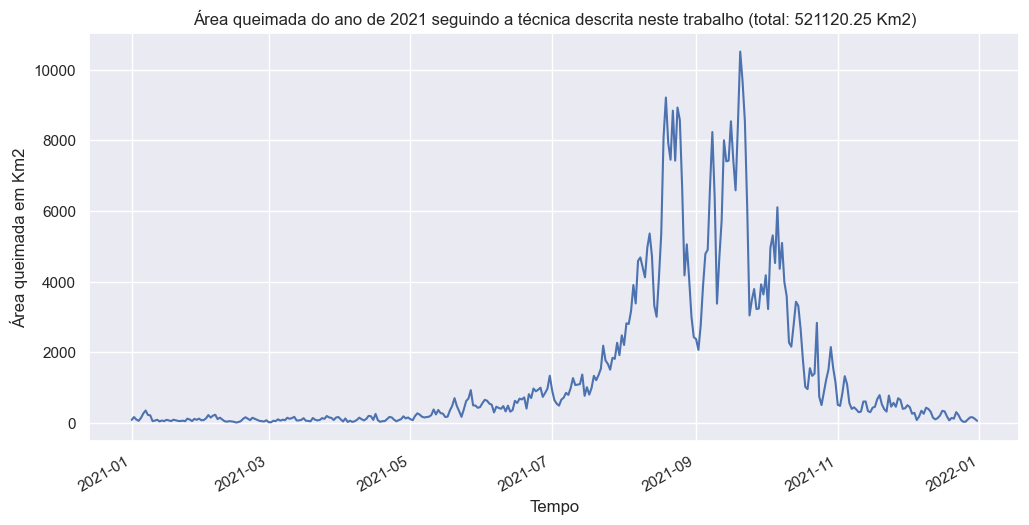

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

data_temp = area_dataframe.loc['2021-01-01':'2021-12-31']
data_temp.plot(ax=ax, legend=False)

ax.set_xlabel('Tempo')
ax.set_ylabel('Área queimada em Km2')
ax.set_title('Área queimada do ano de 2021 seguindo a técnica descrita neste trabalho (total: {:.2f} Km2)'.format(data_temp['area_km2'].sum()))

Text(0.5, 1.0, 'Detecções do AQUA do ano de 2021 (total: 189879)')

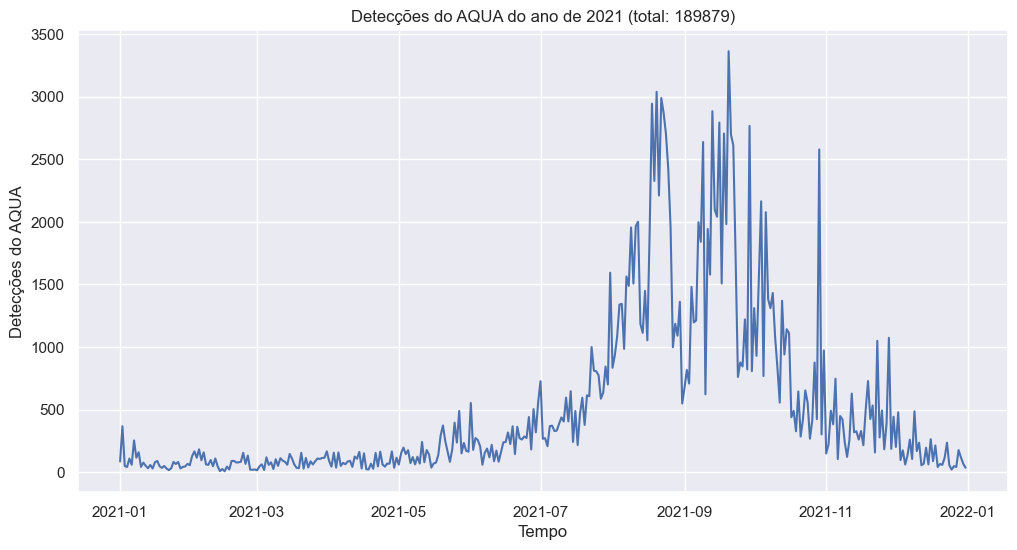

In [ ]:
reference_df = df[(df.satelite == 'AQUA_M-T')].query("'2021-01-01 00:00:00-03:00' < datahora < '2021-12-31 23:59:59-03:00'")

fig, ax = plt.subplots(1, 1, figsize=(12,6))
data_temp = reference_df.groupby([reference_df['datahora'].dt.date])['datahora'].count()
data_temp.plot(ax=ax)

ax.set_xlabel('Tempo')
ax.set_ylabel('Detecções do AQUA')
ax.set_title('Detecções do AQUA do ano de 2021 (total: {})'.format(data_temp.sum()))


In [ ]:
data_temp = df.query("'2022-09-02 00:00:00-03:00' < datahora < '2022-09-02 23:59:59-03:00'")
explorer = SatellitesExplore(data_temp, quadrat_width=0.004)
print('Área queimada:', explorer.get_total_area_m_2() / 1000000, 'Km^2')

Área queimada: 11114.321981290554 Km^2
